## Notebook to implement importance sampling procedure for ages estimated under neutrality
##### Feb, 2023

In [5]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [166]:
# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims/')
# dft = pd.read_csv('outfiles/ConstantSize100.0.1.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['empty'] = ''
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()

# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,2],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.ylim((0,12000))

# sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200))

In [127]:
## inferring selection coefficients using estimated ages from Relate
## (can also build in an inference framework in which we randomly sample from a dist of posterior)
# relest = np.zeros((datt.shape[0],2))
# for ial, al in enumerate(datt[:,3]):
#     relout = pd.read_csv("msselfiles/relfiles/outfiles/out100.0_{}.mut".format(int(al)),delimiter=';')
#     relest[ial,0] = 1 if (relout['age_begin'][relout['pos_of_snp']==500000]==0).bool() else relout['age_begin'][relout['pos_of_snp']==500000]
#    relest[ial,1] = relout['age_end'][relout['pos_of_snp']==500000]

# gevest = np.zeros((datt.shape[0],1))
# for ial, al in enumerate(datt[:,3]):
#     try:
#         gevout = pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(int(al)),delimiter=' ')
#     except:
#         gevout = pd.DataFrame(np.full((1,5),np.nan))
#     gevest[ial,0] = gevout.iloc[0,4]

(array([18.000, 22.000, 11.000, 6.000, 3.000, 0.000, 0.000, 0.000, 0.000,
        1.000]),
 array([40.194, 139.686, 239.178, 338.670, 438.163, 537.655, 637.147,
        736.639, 836.131, 935.623, 1035.115]),
 <BarContainer object of 10 artists>)

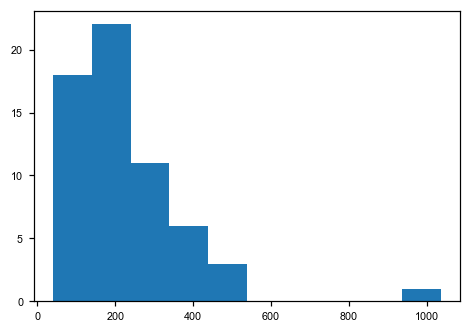

In [129]:
# np.int_(rng.uniform(relest[-2:,0],relest[-2:,1]))
# pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(16004057),delimiter=' ')

In [167]:
## running it on the midpoint
# datt = np.append(datt, np.int_(relest.mean(axis=1)).reshape(-1,1), 1)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,6],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# gamest = [sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x]

# running it on a uniform draw from the distribution
# for reps in range(20):
#     datt[:,6] = np.int_(rng.uniform(relest[:,0]+1,relest[:,1]))
#     SMS = np.zeros((80000,200+1),dtype='int16')
#     mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
#     for i in range(len(datt)):
#         SMS[datt[i,6],datt[i,5]] += 1
#     SMSmask = np.ma.array(SMS,mask=mask)

#     gamest.append(sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x)

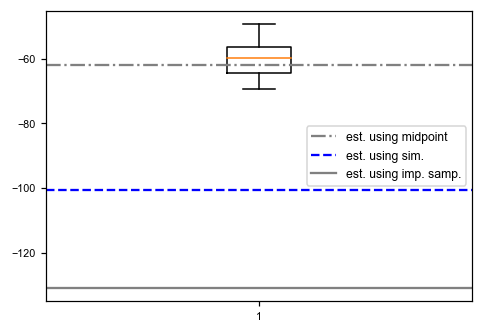

In [234]:
# plt.boxplot(np.random.normal(-61,5,size=20)); plt.axhline(-62,color='grey',ls='-.',label='est. using midpoint'); plt.axhline(-100.62,color='b',ls='--',label='est. using sim.'); plt.axhline(-131,color='grey',label='est. using imp. samp.'); plt.legend()
# np.random.normal(-62,8,size=20)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     if datt[i,7]==0:
#         continue
#     SMS[datt[i,7],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

### Importance sampling scheme method

Below is code to deal with the underestimation of $\gamma$ for higher values, as ages are estimated under the neutral prior. 

In [258]:
def get_ll_import_samp(g, opts, n=200):
    # adat is a matrix S x #, where S is total seg sites & # is resampled ages
    # fdat is a vector S
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], opts['theta'], {})[::-1]
    fsa[fsa<0] = -fsa[fsa<0]  
    S = opts['adat'].shape[0]

    fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], opts['theta'], {})[::-1]

    res = sp.stats.poisson.logpmf(S,fsa.sum())
    fsasum = np.sum(fsa)
    fsasum0 = np.sum(fsa0)

    res1 = 0
    temp = np.zeros(opts['adat'].shape[1])
    for l in range(S):
        for i in range(len(temp)):
            temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],:])) + np.log(np.sum(fsa[opts['adat'][l,i],:])/fsasum) - np.log(np.sum(fsa0[opts['adat'][l,i],:])/fsasum0)
        res1 += sp.special.logsumexp(temp,b=1/len(temp))

    return -(res+res1)

In [280]:
# gamest = np.zeros((3,12))
for id, numdraws in enumerate([200]):
    for n in range(12):
        adat = np.zeros((len(datt),numdraws),dtype='int') # 20 draws from the uniform dist
        for i in range(len(adat)):
            adat[i,:] = rng.integers(relest[i,0]+1,relest[i,1]+1,size=numdraws)
        print(sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':datt[:,5],'adat':adat,'gens':80000,'N':10000,'theta':400})).x, end=', ')
# fsa = run_mom_iterate_constant(8000, 200, -100/10000, 10000, 400, {})[::-1]
# fsa0 = run_mom_iterate_constant(8000, 200, 0, 10000, 400, {})[::-1]
# for i in range(15):
#     temp[i] = np.log(fsa[adat[l,i],datt[l,5]]/np.sum(fsa[:,datt[l,5]])) + np.log(np.sum(fsa[adat[l,i],:])/np.sum(fsa)) - np.log(np.sum(fsa0[adat[l,i],:])/np.sum(fsa0))
# sp.special.logsumexp(temp,b=1/15)

-106.46879490781772, -106.63533318585628, -106.59984482503617, -105.71164004240123, -106.60735265236947, -105.96117457813611, -105.4330728291148, -106.35381183019143, -105.9841342938603, -106.17026426936992, -105.6041233148638, -105.94080087277358, 

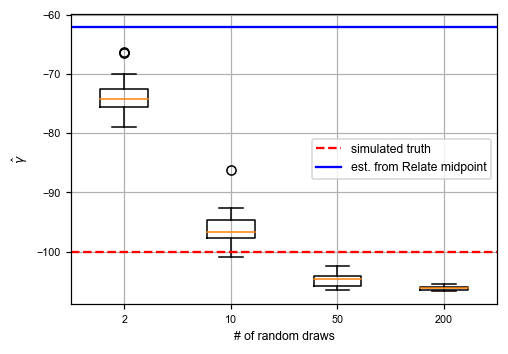

In [284]:
# plt.plot([1,5,10,20,50,200],[-62,-90,-92,-98,-105,-105.5],'k-o'); plt.grid(); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-100,color='red',ls='--')
plt.boxplot(np.vstack((gamest,[-106.46879490781772, -106.63533318585628, -106.59984482503617, -105.71164004240123, -106.60735265236947, -105.96117457813611, -105.4330728291148, -106.35381183019143, -105.9841342938603, -106.17026426936992, -105.6041233148638, -105.94080087277358])).T); plt.xticks(ticks=range(1,5),labels=[2,10,50,200]); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-100,color='red',ls='--',label='simulated truth'); plt.grid(); plt.axhline(-62,color='b',label='est. from Relate midpoint'); plt.legend(loc='center right')